# find a golden cuts-point using symplex algorithm + manual scanning

In [1]:
import sys; sys.path.insert(0, '../../AnaTreesPackage/notebooks')
from notebooks_tools import * 
from ccqe_notebook_tools import *
from matplotlib import ticker
import scipy.optimize as optimize
%matplotlib inline

# load the data

In [2]:
extBNB2tracks = pd.read_csv('/Users/erezcohen/Desktop/uBoone/analysis/ccqe_candidates/ccqe_candidates_CC1pTopology_MCC7_extBNB.csv')
print len(extBNB2tracks),'extBNB 2-tracks clusters'
OpenCosmic2tracks = pd.read_csv('/Users/erezcohen/Desktop/uBoone/analysis/ccqe_candidates/ccqe_candidates_CC1pTopology_MCC7_openCOSMIC_MC.csv')
print len(OpenCosmic2tracks),'OpenCosmic 2-tracks clusters'

66546 extBNB 2-tracks clusters
17560 OpenCosmic 2-tracks clusters


In [113]:
MCevents = pd.read_csv('/Users/erezcohen/Desktop/uBoone/analysis/ccqe_candidates/ccqe_candidates_CC1pTopology_MCC7_MC_BNB.csv')
# MCevents = pd.read_csv('/Users/erezcohen/Desktop/uBoone/analysis/ccqe_candidates/ccqe_candidates_CC1pTopology_MCC7_MC_BNB_InTimeCOSMIC_MC.csv')
print len(MCevents),'2-tracks clusters from MC-BNB events'

MCeventsTrueCC1p = MCevents[MCevents.GENIECC1p==1]
print len(MCeventsTrueCC1p), 'are true (GENIE) cc1p'

MCeventsTrueCC1pAndTagged = MCeventsTrueCC1p[MCeventsTrueCC1p.l_large_pida < MCeventsTrueCC1p.l_small_pida]
print len(MCeventsTrueCC1pAndTagged), 'are true (GENIE) cc1p in which l(large-PID_A)<l(small-PID_A)'

MCeventsNonTrueCC1p = MCevents[MCevents.GENIECC1p!=1]
print len(MCeventsNonTrueCC1p), 'are non true (GENIE) cc1p'

# MCeventsNonTrueCC1p1mu1p = MCevents[(MCevents.Is1mu1p==True) & (MCevents.GENIECC1p==False)]
# print len(MCeventsNonTrueCC1p1mu1p), 'are 2-tracks clusters of 1µ1p'

MCeventsNonTrueCC1p1mu1p = MCeventsNonTrueCC1p[(MCeventsNonTrueCC1p.pdg_long*MCeventsNonTrueCC1p.pdg_short == 28756)]
print len(MCeventsNonTrueCC1p1mu1p), 'are 2-tracks clusters of 1µ1p'


# MCeventsNon1mu1p = MCevents[MCevents.Is1mu1p==False]
# print len(MCeventsNon1mu1p), 'are 2-tracks not 1µ1p'

MCeventsNon1mu1p = MCeventsNonTrueCC1p[(MCeventsNonTrueCC1p.pdg_long*MCeventsNonTrueCC1p.pdg_short != 28756)]
print len(MCeventsNon1mu1p), 'are 2-tracks not 1µ1p'

print len(MCeventsNonTrueCC1p1mu1p) +  len(MCeventsNon1mu1p), ' 1µ1p and not 1µ1p together'
samples = [MCeventsTrueCC1p , MCeventsTrueCC1pAndTagged , MCeventsNonTrueCC1p1mu1p, MCeventsNon1mu1p , extBNB2tracks, OpenCosmic2tracks]
labels = ['MC-BNB true(GENIE) CC1p' , 'true CC1p, l(large-PIDA)<l(small-PIDA)' , '1$\\mu$1p non CC1p' , 'non 1$\\mu$1p' , 'ext-BNB 2-tracks clusters', 'open-cosmic MC']

8153 2-tracks clusters from MC-BNB events
703 are true (GENIE) cc1p
570 are true (GENIE) cc1p in which l(large-PID_A)<l(small-PID_A)
7450 are non true (GENIE) cc1p
1108 are 2-tracks clusters of 1µ1p
6342 are 2-tracks not 1µ1p
7450  1µ1p and not 1µ1p together


In [6]:
def sample_in_selected_cut( data=None, label='' ,do_print=False
                           ,FV_y_max = 110 # [cm]
                           ,delta_Delta_phi = 180 # around 180 [deg.]
                           ,theta_pq_max = 180 # [deg.]
                           ,delta_p_over_q = 2
                           ,delta_cfdistance = 200 # closest flash distance [cm]
#                            ,delta_2_tracks_angle = 100 # angle between the two tracks
                           ,minimal_PIDA_large_pida=0
                           ,maximal_PIDA_small_pida=200
                           ,minimal_length_long = 0 # [cm]
                           ,maximal_length_short = 1000 # [cm]
                           ,max_Pt=100 # [GeV/c]
                           ,Xb_min=0.2
                           ,Xb_Pt_correlation_width=0.5
                           ,W2_max = 2
                           ,dqdx_around_vertex_non_tracks_associated_max=20000
                           ,large_pidA_small_pidA_ratio_min=0
                          ):
    average_p_over_q = np.average(MCeventsTrueCC1p['reco_CC1p_p_over_q'])
    average_delta_phi = np.average(MCeventsTrueCC1p['delta_phi'])
    
    reduced = data[                     
        # define a new FV cut for cosmic supression
        (np.fabs(data['starty_short']) < FV_y_max)        
        & (np.fabs(data['starty_long']) < FV_y_max)
        & (np.fabs(data['endy_short']) < FV_y_max)        
        & (np.fabs(data['endy_long']) < FV_y_max)        

        # match the closest flash
        & (np.fabs(data['cfdistance_long']) < delta_cfdistance)
        & (np.fabs(data['cfdistance_short']) < delta_cfdistance)        

        # cut on delta \phi for QE topology - QE physics
        & (np.fabs(data['delta_phi']-average_delta_phi) < delta_Delta_phi)        
        & (data['reco_CC1p_Xb'] > Xb_min)        
        & (data['reco_CC1p_Pt'] < max_Pt)
        & (data['reco_CC1p_omega'] > 0.0)        
        & (data['reco_CC1p_Ev'] > 0.0)
        # hypothesis of CC1p
        & (data['reco_CC1p_Pmu_x'] + data['reco_CC1p_Pp_x'] < max_Pt)
        & (data['reco_CC1p_Pmu_y'] + data['reco_CC1p_Pp_y'] < max_Pt)
        & ( data['reco_CC1p_W2'] < W2_max )
        & ( data['reco_CC1p_n_miss'] < 1. )


        
        # cut on reconstructed \theta(p,q) - this comes only from physics - QE physics
        & ( data['reco_CC1p_theta_pq'] < theta_pq_max )
        # cut on reconstructed p/q - this comes only from physics - QE physics
        & ( np.fabs(data['reco_CC1p_p_over_q']-average_p_over_q) < delta_p_over_q )
        # angle between the two tracks
        #         & ( np.fabs(180./np.pi*data['2_tracks_angle']-90) < delta_2_tracks_angle )        

        # pid-A of the higher ionizing track
        & ( data['PIDA_large_pida'] > minimal_PIDA_large_pida )        
        # pid-A of the less ionizing track
        & ( data['PIDA_small_pida'] < maximal_PIDA_small_pida )
        & ( data['PIDA_large_pida']/data['PIDA_small_pida'] > large_pidA_small_pidA_ratio_min )

        # length of the long track        
        & ( data['l_long'] > minimal_length_long )        
        # length of the short track        
        & ( data['l_short'] < maximal_length_short )        
        
        # new cuts
        # test - would it help if we demand that the length of the 'muon' is longer than the length of the 'proton'
        & ( data['l_large_pida'] < data['l_small_pida'] )
        & ( np.fabs(data['reco_CC1p_Xb'] - (0.75-5*data['reco_CC1p_Pt'])) < Xb_Pt_correlation_width )
        & ( data['dqdx_around_vertex_non_tracks_associated'] <= dqdx_around_vertex_non_tracks_associated_max )
        & (data['reco_CC1p_Ev_from_angles_Ev_from_mu_p_diff'] < 2)
    ]    
    frac = 100.0 * float(len(reduced)) / float(len(data))
    frac_err = frac * np.sqrt( 1./len(reduced) + 1./len(data) ) if len(reduced)>0 else frac / np.sqrt(len(data))
    if do_print: print label,"retained %.2f +/- %.2f"%(frac,frac_err)+ "% in this cut " + "(%d pairs)"%len(reduced)
    return reduced , frac , frac_err

In [7]:
def frac_in_cut(sample=None,x=None):
    [FV_y_max ,
     delta_Delta_phi ,
     theta_pq_max ,
     delta_p_over_q ,
     delta_cfdistance , 
     minimal_PIDA_large_pida ,
     maximal_PIDA_small_pida ,
     large_pidA_small_pidA_ratio_min,
     minimal_length_long ,
     maximal_length_short , 
     max_Pt,
     Xb_min ,
     Xb_Pt_correlation_width ,
     W2_max ,
     dqdx_around_vertex_non_tracks_associated_max ] = x
    
    r,frac,f_err = sample_in_selected_cut( data=sample, label='' ,do_print=False
                                           ,FV_y_max=FV_y_max # [cm]
                                           ,delta_Delta_phi = delta_Delta_phi # around 180 [deg.]
                                           ,theta_pq_max = theta_pq_max # [deg.]
                                           ,delta_p_over_q = delta_p_over_q 
                                           ,delta_cfdistance = delta_cfdistance # closest flash distance [cm]
                                           ,minimal_PIDA_large_pida=minimal_PIDA_large_pida
                                           ,maximal_PIDA_small_pida=maximal_PIDA_small_pida
                                          ,large_pidA_small_pidA_ratio_min = large_pidA_small_pidA_ratio_min
                                           ,minimal_length_long = minimal_length_long # [cm]                                            
                                          ,maximal_length_short = maximal_length_short # [cm]                                          
                                          ,max_Pt=max_Pt
                                          ,Xb_min=Xb_min
                                          ,Xb_Pt_correlation_width=Xb_Pt_correlation_width
                                          ,W2_max=W2_max 
                                          ,dqdx_around_vertex_non_tracks_associated_max=dqdx_around_vertex_non_tracks_associated_max
                                            #                                            ,delta_2_tracks_angle = delta_2_tracks_angle
                                         )
    return frac

In [8]:
def reduced_in_cut(sample=None,x=None):
    [FV_y_max ,
     delta_Delta_phi ,
     theta_pq_max ,
     delta_p_over_q ,
     delta_cfdistance , 
     minimal_PIDA_large_pida ,
     maximal_PIDA_small_pida ,
     large_pidA_small_pidA_ratio_min,
     minimal_length_long ,
     maximal_length_short , 
     max_Pt,
     Xb_min ,
     Xb_Pt_correlation_width ,
     W2_max ,
     dqdx_around_vertex_non_tracks_associated_max ] = x
    
    r,frac,f_err = sample_in_selected_cut( data=sample, label='' ,do_print=False
                                           ,FV_y_max=FV_y_max # [cm]
                                           ,delta_Delta_phi = delta_Delta_phi # around 180 [deg.]
                                           ,theta_pq_max = theta_pq_max # [deg.]
                                           ,delta_p_over_q = delta_p_over_q 
                                           ,delta_cfdistance = delta_cfdistance # closest flash distance [cm]
                                           ,minimal_PIDA_large_pida=minimal_PIDA_large_pida
                                           ,maximal_PIDA_small_pida=maximal_PIDA_small_pida
                                          ,large_pidA_small_pidA_ratio_min = large_pidA_small_pidA_ratio_min
                                           ,minimal_length_long = minimal_length_long # [cm]                                            
                                          ,maximal_length_short = maximal_length_short # [cm]                                          
                                          ,max_Pt=max_Pt
                                          ,Xb_min=Xb_min
                                          ,Xb_Pt_correlation_width=Xb_Pt_correlation_width
                                          ,W2_max=W2_max 
                                          ,dqdx_around_vertex_non_tracks_associated_max=dqdx_around_vertex_non_tracks_associated_max
                                            #                                            ,delta_2_tracks_angle = delta_2_tracks_angle
                                         )
    return r

In [9]:
def print_final_frac_in_samples(values):
    number = []
    for i,sample,label in zip(range(len(samples)),samples,labels):
        f = frac_in_cut(sample=sample,x=values)
        number.append(0.01*f*len(sample))
        print label , ': %.2f'%f + '%' + '(%d)'%number[i]
    for i,sample,label in zip(range(2),samples,labels):
        print label , 'purity: %.2f'%(float(number[i])/(number[i]+number[2]+number[3]+10*number[4]+10*number[5]))

# manual scan 

In [97]:
#   y(max) ,
#   𝚫ɸ ,
#   𝜃(p,q) ,
#   p/q ,
#   cfdis , 
#   large-pida(min) ,
#   small-pida(max) ,
#   l-long(min) ,
#   l-short(max) , 
#   Pt(max),
#   Xb(min),
#   Xb-Pt(width)
#   W2-max ,
#   dq/dx around vertex non-tracks-associated (max) 
print_final_frac_in_samples([98,15,10,0.2,83,10,10,15,100,0.15,0.1,0.4,1.2,10000])
print 
# print_final_frac_in_samples([ 110. , 20. , 10. , 0.1 , 500 , 15. , 25 , 50 , 100 , 0.1 , 0.1 , 0.2 ])

MC-BNB true(GENIE) CC1p : 4.17%(42)
true CC1p, l(large-PIDA)<l(small-PIDA) : 5.07%(42)
1$\mu$1p non CC1p : 0.06%(1)
non 1$\mu$1p : 0.03%(12)
ext-BNB 2-tracks clusters : 0.00%(0)
open-cosmic MC : 0.00%(0)
MC-BNB true(GENIE) CC1p purity: 0.76
true CC1p, l(large-PIDA)<l(small-PIDA) purity: 0.76



# using symplex

In [178]:
def max_eff_in_selected_cuts(x):
    frac,number = [],[]
    for i,sample,label in zip(range(len(samples)),samples,labels):
        f = frac_in_cut(sample=sample,x=x)
        frac.append(f)
        number.append(0.01*f*len(sample))
    efficiency = frac[0]        
    purity = number[0]/(number[0]+number[2]+number[3]+number[4]+number[5]) if sum(number)>0 else sum(number)
    result = -purity #  10*(frac[2]+frac[3])-frac[0]
    if frac[0]>2 and frac[2]<0.1 and frac[3]<0.1:
        print x
        print frac
        print 'purity:',purity
#         print 'result:',result        
        print        
    return result

#     purity = frac[0]/(frac[0] + 10*frac[2] + frac[3] + frac[4]) if (frac[0] + frac[2] + frac[3] + frac[4])>0 and frac[0]>10 else frac[2] + frac[3] + frac[4]
#     return 5*(frac[2]+frac[3]+frac[4])-frac[0]
#     return -purity*efficiency
#     return -(frac[0])*np.abs((1-frac[1]*100000)*(1-frac[2]*100000)*(1-frac[3]*100000))

In [180]:
# y(max), 𝚫ɸ, 𝜃(p,q), p/q, cfdis, large-pida(min), small-pida(max), l_long(min), l_short(max), Pt(max), Xb(min), Xb-Pt(width)
init = [99.087, 10, 8, 0.3, 97.63, 18.4, 14.9, 3, 21.3, 117.3, 0.25, 0.01, 0.79, 1.327, 10245.0]
steps = init # [2 , 5. , 5 , 0.2 , 30 , 11 , 11 , 1 , 10 , 30 , 0.15 , 0.01 ,0.2 ,0.5 , 500 ] 
s = Simplex(max_eff_in_selected_cuts, init, steps) 
v, err, iter = s.minimize(epsilon = 0.1, maxiters = 100, monitor = 0)
del(s)
print 'finished after ', iter,'iterations'
print v
print_final_frac_in_samples(v)

[99.087, 10, 8, 0.3, 97.63, 18.4, 14.9, 3, 21.3, 117.3, 0.25, 0.01, 0.79, 1.327, 10245.0]
[2.0833333333333335, 2.5331724969843186, 0.06218905472636816, 0.0050685521680731895, 0.0, 0.0]
purity: 0.875
result: -0.875

[198.174, 10, 8, 0.3, 97.63, 18.4, 14.9, 3, 21.3, 117.3, 0.25, 0.01, 0.79, 1.327, 10245.0]
[2.1825396825396823, 2.6537997587454765, 0.06218905472636816, 0.007602828252109785, 0.0030054398461214797, 0.0]
purity: 0.785714285714
result: -0.785714285714

[99.087, 20, 8, 0.3, 97.63, 18.4, 14.9, 3, 21.3, 117.3, 0.25, 0.01, 0.79, 1.327, 10245.0]
[2.7777777777777777, 3.3775633293124248, 0.06218905472636816, 0.012671380420182975, 0.0, 0.0]
purity: 0.823529411765
result: -0.823529411765

[99.087, 10, 16, 0.3, 97.63, 18.4, 14.9, 3, 21.3, 117.3, 0.25, 0.01, 0.79, 1.327, 10245.0]
[2.7777777777777777, 3.3775633293124248, 0.06218905472636816, 0.010137104336146379, 0.0, 0.0]
purity: 0.848484848485
result: -0.848484848485

[99.087, 10, 8, 0.3, 195.26, 18.4, 14.9, 3, 21.3, 117.3, 0.25, 0.01, 

# reduced samples charecteristics

In [114]:
#   y(max) ,
#   𝚫ɸ ,
#   𝜃(p,q) ,
#   p/q ,
#   cfdis , 
#   large-pida(min) ,
#   small-pida(max) ,
#   l-long(min) ,
#   l-short(max) , 
#   Pt(max),
#   Xb(min),
#   Xb-Pt(width)
#   W2-max ,
#   dq/dx around vertex non-tracks-associated (max) 
init = [98.087, 14, 11, 0.5, 97.63, 6.4, 109.9, 1, 21.3, 117.3, 0.25, 0.0, 2.79, 1.527, 20245.0]
reduced, number = [] , []
for sample,label in zip(samples,labels):
    r = reduced_in_cut(sample=sample,x=init)
    reduced.append(r)
    number.append(len(r))
    print label,':',number[-1]
    
print 'purity: %.2f'%(float(number[0])/(number[0]+number[2]+number[3]+number[4]))

MC-BNB true(GENIE) CC1p : 152
true CC1p, l(large-PIDA)<l(small-PIDA) : 152
1$\mu$1p non CC1p : 23
non 1$\mu$1p : 10
ext-BNB 2-tracks clusters : 1
open-cosmic MC : 0
purity: 0.82


In [135]:
weird = reduced[2][(reduced[2].closest_genie_Np==1) & (reduced[2].closest_genie_Nn==0) &(reduced[2].closest_genie_Npi==0) & (reduced[2].closest_genie_Nel==0)]
weird[['run','subrun','event','pdg','process_primary','distance','truth_startx','startx','truth_starty','starty','truth_startz','closest_genie_x','closest_genie_y','closest_genie_distance','vertex_x','vertex_y','closest_genie_Ev','reco_CC1p_Ev']]
# weird = reduced[2]
# weird[['run','subrun','event','pdg','process_primary','distance','truth_startx','startx','truth_starty','starty','closest_genie_Np','closest_genie_Npi','closest_genie_Nn','closest_genie_distance','vertex_x','vertex_y','vertex_z','closest_genie_Ev','reco_CC1p_Ev']]


,run,subrun,event,pdg,process_primary,distance,truth_startx,startx,truth_starty,starty,truth_startz,closest_genie_x,closest_genie_y,closest_genie_distance,vertex_x,vertex_y,closest_genie_Ev,reco_CC1p_Ev
549,6,9387,187740,"[13, 2212]","[1, 0]",0.538813,"[35.08827209472656, 23.97632598876953]","[35.825469970703125, 35.65011215209961]","[83.78060913085938, 91.22509002685547]","[83.59664916992188, 83.8502197265625]","[899.8809204101562, 915.5449829101562]",35.0883,83.7806,0.793776,35.8255,83.59660,0.844258,0.826801
990,7,1972,39421,"[13, 2212]","[1, 0]",0.877563,"[109.72483825683594, 118.20098114013672]","[109.58136749267578, 110.10150909423828]","[-17.26024055480957, -19.785999298095703]","[-17.1527156829834, -17.26732063293457]","[1000.5719604492188, 1020.0153198242188]",109.7250,-17.2602,0.357847,109.5810,-17.15270,0.608246,0.723890
3360,4,4379,87577,"[2212, 13]","[1, 1]",0.479865,"[150.3711395263672, 150.3711395263672]","[150.8449249267578, 132.92454528808594]","[3.7405974864959717, 3.7405974864959717]","[3.6612160205841064, -8.548688888549805]","[277.00225830078125, 277.00225830078125]",150.3710,3.7406,0.630419,150.8450,3.66122,0.422042,0.411759
4158,6,4121,82412,"[13, 2212]","[1, 0]",0.631649,"[39.45039367675781, 33.5740966796875]","[40.439659118652344, 40.080291748046875]","[32.19059753417969, 30.670166015625]","[32.214271545410156, 32.09593200683594]","[919.873291015625, 929.6138305664062]",39.4504,32.1906,1.003710,40.4397,32.21430,0.814675,0.639230
4161,7,4298,85944,"[13, 2212]","[1, 0]",0.900152,"[155.32376098632812, 152.20191955566406]","[156.61184692382812, 155.8585205078125]","[17.51229476928711, 17.95475196838379]","[19.01361846923828, 19.168163299560547]","[14.040926933288574, 25.264921188354492]",155.3240,17.5123,2.014000,156.6120,19.01360,0.795065,0.734279
6831,1,2016,40316,"[13, 2212]","[1, 0]",0.598885,"[87.43598175048828, 83.18197631835938]","[87.87309265136719, 87.69538116455078]","[24.09372901916504, 21.383861541748047]","[24.112350463867188, 23.910795211791992]","[437.54901123046875, 443.0821533203125]",87.4360,24.0937,0.452320,87.8731,24.11240,0.770391,0.787835


In [134]:
reduced[3][['run','subrun','event','pdg','pida','truth_startx','truth_starty','truth_startz','closest_genie_distance','closest_genie_Np','closest_genie_Npi','closest_genie_Nn','closest_genie_Nel','closest_genie_Ngamma','closest_genie_Nmu','vertex_x','vertex_y','vertex_z']]

,run,subrun,event,pdg,pida,truth_startx,truth_starty,truth_startz,closest_genie_distance,closest_genie_Np,closest_genie_Npi,closest_genie_Nn,closest_genie_Nel,closest_genie_Ngamma,closest_genie_Nmu,vertex_x,vertex_y,vertex_z
733,5,3848,76943,"[2212, 2212]","[25.305639266967773, 12.518936157226562]","[220.99215698242188, 195.46328735351562]","[-71.1664047241211, -7.734018802642822]","[171.4158935546875, 150.5079803466797]",97.869500,1,1,1,0,0,1,221.2610,-70.1698,170.757
1479,7,1974,39478,"[2212, 211]","[20.09491539001465, 7.790020942687988]","[100.65391540527344, 75.88575744628906]","[-21.72036361694336, -2.173401117324829]","[914.677490234375, 881.6132202148438]",45.770900,2,1,1,0,0,1,101.1130,-21.5780,914.507
2837,7,3774,75474,"[22, 2212]","[9.106063842773438, 18.98541831970215]","[187.22518920898438, 187.22518920898438]","[-68.51996612548828, -68.51997375488281]","[902.372802734375, 902.372802734375]",10.557700,1,1,1,0,0,0,193.5420,-60.9093,906.066
3611,5,8251,165019,"[2212, 22]","[17.751937866210938, 7.083423614501953]","[137.782470703125, 137.782470703125]","[-69.74701690673828, -69.74701690673828]","[612.7244873046875, 612.7244873046875]",0.622297,1,1,1,0,0,0,138.2900,-69.9384,613.030
4620,4,3227,64532,"[211, 2212]","[8.661162376403809, 15.961483001708984]","[213.70901489257812, 213.70901489257812]","[-87.66498565673828, -87.66498565673828]","[389.51165771484375, 389.51165771484375]",0.538724,2,1,0,0,0,1,213.4690,-87.2221,389.702
4780,5,7459,149172,"[211, 2212]","[9.430013656616211, 21.516469955444336]","[79.19955444335938, 79.19955444335938]","[-10.577085494995117, -10.577085494995117]","[877.78515625, 877.78515625]",1.506890,1,1,2,0,0,0,80.6430,-10.8009,878.155
4807,4,4891,97806,"[211, 2212]","[13.623448371887207, 19.3265323638916]","[170.15248107910156, 170.15248107910156]","[30.40971565246582, 30.40971565246582]","[767.6857299804688, 767.6857299804688]",0.350811,1,1,0,0,0,1,170.3800,30.6028,767.501
4910,7,3306,66104,"[22, 2212]","[11.370416641235352, 18035.591796875]","[48.30936813354492, 48.309364318847656]","[-22.759552001953125, -22.75954818725586]","[395.6458435058594, 395.6458435058594]",8.400820,4,1,3,0,0,0,51.5299,-30.5098,396.014
7428,7,1280,25586,"[2212, 211]","[17.855905532836914, 7.2030415534973145]","[196.0023651123047, 168.51394653320312]","[72.21659088134766, 46.49282455444336]","[141.18089294433594, 136.2866973876953]",37.531300,1,1,0,0,0,1,196.0660,71.5009,141.195
7496,1,2689,53770,"[11, 13]","[25.94477653503418, 13.88996696472168]","[203.53111267089844, 214.6667938232422]","[75.6189193725586, 49.61157989501953]","[341.45758056640625, 357.2020568847656]",28.428800,3,0,2,0,0,1,204.2010,74.8448,349.331


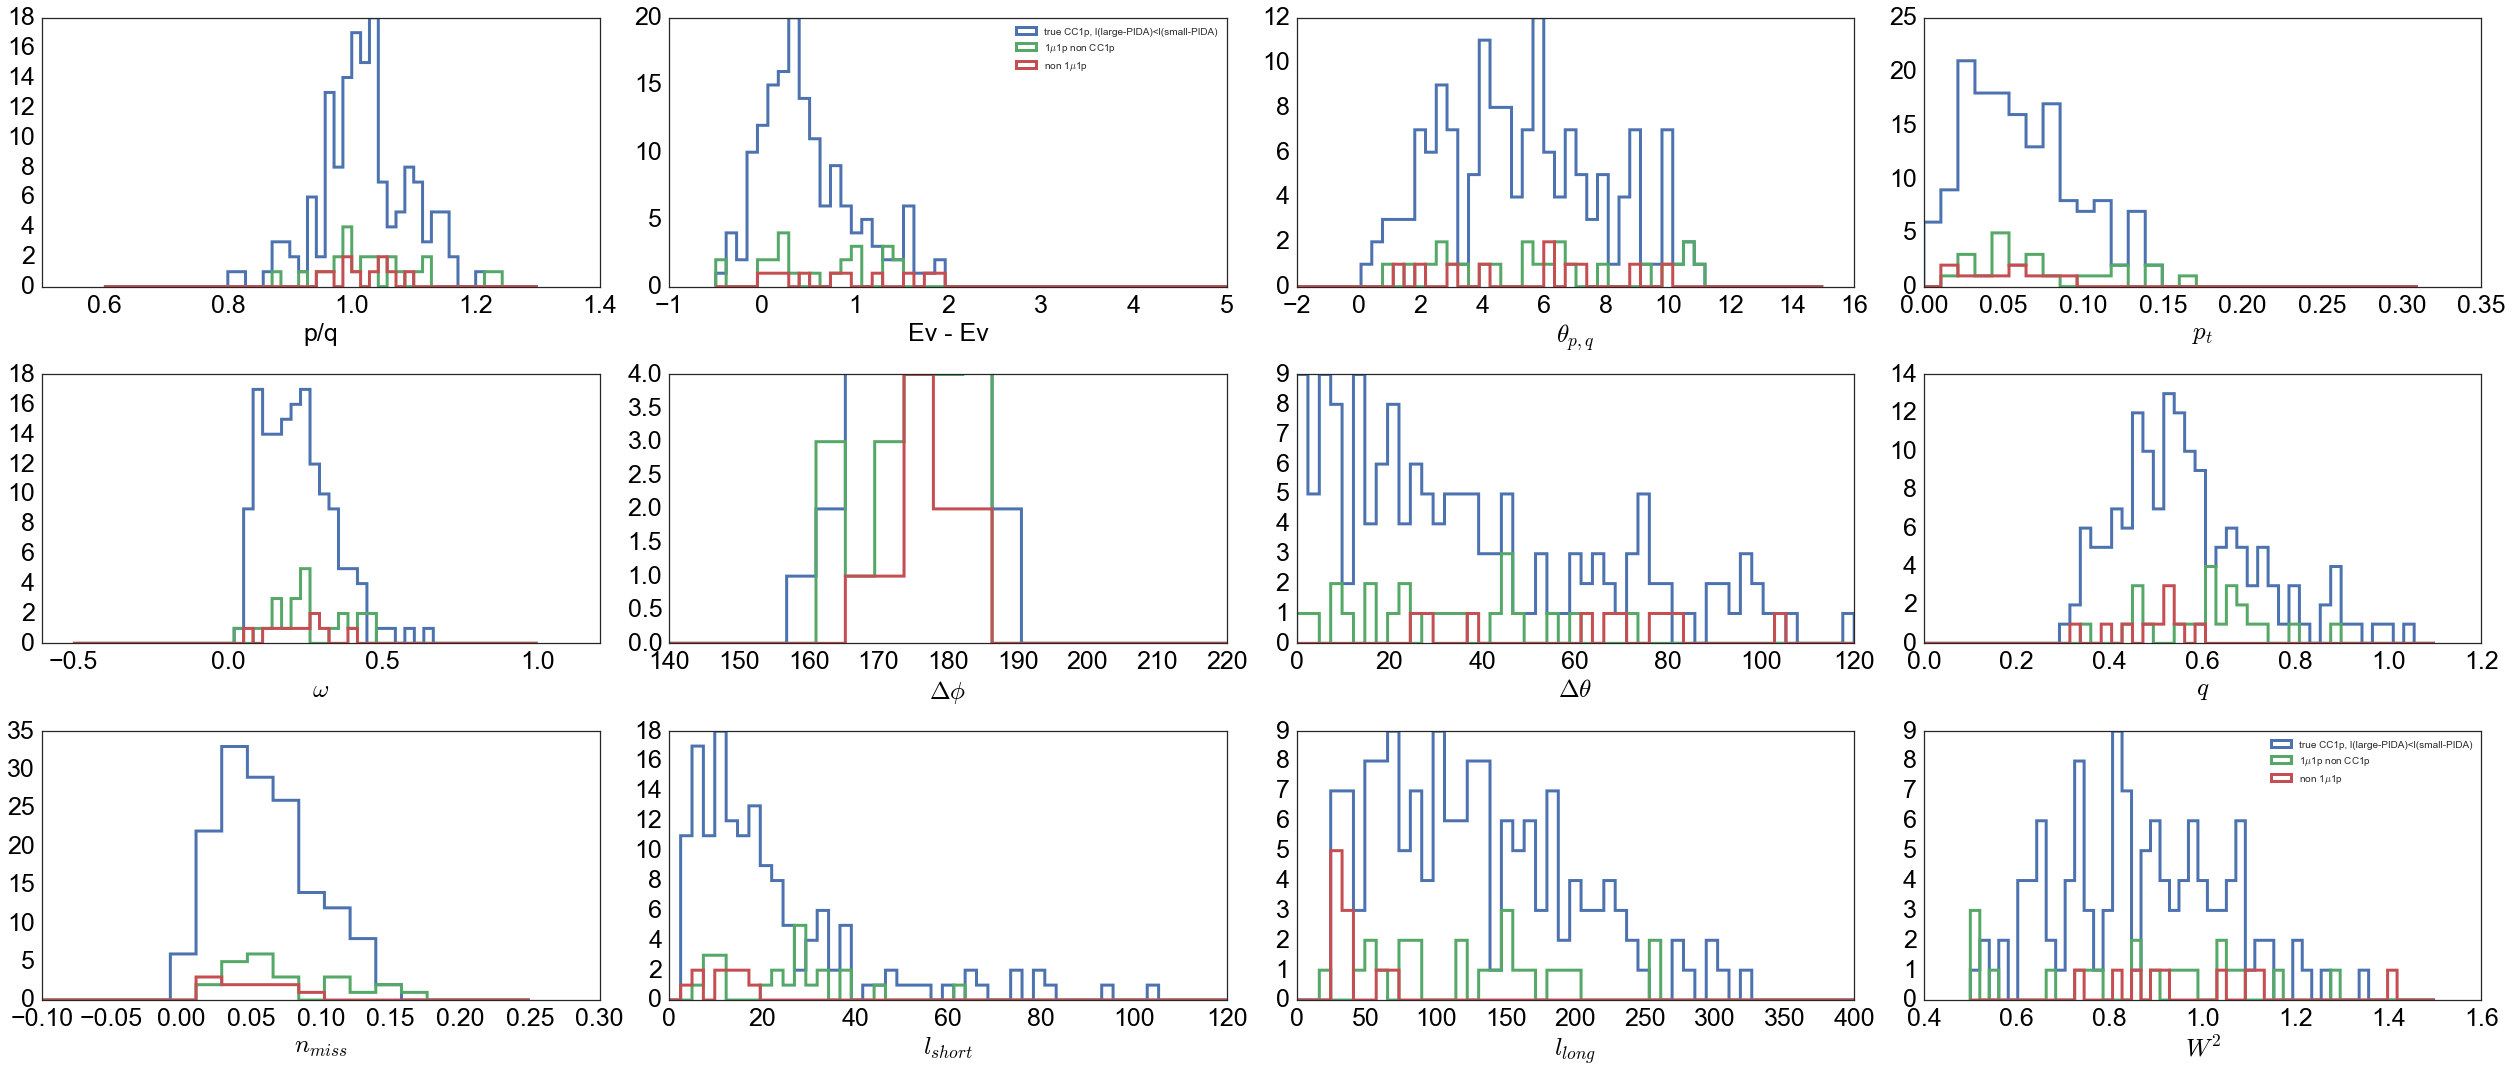

In [122]:
fig=plt.figure(figsize=(35,15))
ax =fig.add_subplot(3,4,1) 
bins=np.linspace(0.6,1.3,50)
plt.hist(reduced[1].reco_CC1p_p_over_q,histtype='step',bins=bins,linewidth=3,label=labels[1]);
plt.hist(reduced[2].reco_CC1p_p_over_q,histtype='step',bins=bins,linewidth=3,label=labels[2]);
plt.hist(reduced[3].reco_CC1p_p_over_q,histtype='step',bins=bins,linewidth=3,label=labels[3]);
set_axes(ax,x_label='p/q')

ax =fig.add_subplot(3,4,2) 
bins=np.linspace(-.5,5,50)
plt.hist(reduced[1].reco_CC1p_Ev_from_angles_Ev_from_mu_p_diff,histtype='step',bins=bins,linewidth=3,label=labels[1]);
plt.hist(reduced[2].reco_CC1p_Ev_from_angles_Ev_from_mu_p_diff,histtype='step',bins=bins,linewidth=3,label=labels[2]);
plt.hist(reduced[3].reco_CC1p_Ev_from_angles_Ev_from_mu_p_diff,histtype='step',bins=bins,linewidth=3,label=labels[3]);
set_axes(ax,x_label='Ev - Ev')
plt.legend()

ax =fig.add_subplot(3,4,3) 
bins=np.linspace(-2,15,50)
plt.hist(reduced[1].reco_CC1p_theta_pq,histtype='step',bins=bins,linewidth=3,label=labels[1]);
plt.hist(reduced[2].reco_CC1p_theta_pq,histtype='step',bins=bins,linewidth=3,label=labels[2]);
plt.hist(reduced[3].reco_CC1p_theta_pq,histtype='step',bins=bins,linewidth=3,label=labels[3]);
set_axes(ax,x_label='$\\theta_{p,q}$')




ax =fig.add_subplot(3,4,4) 
bins=np.linspace(-0.,0.31,30)
plt.hist(reduced[1].reco_CC1p_Pt,histtype='step',bins=bins,linewidth=3,label=labels[1]);
plt.hist(reduced[2].reco_CC1p_Pt,histtype='step',bins=bins,linewidth=3,label=labels[2]);
plt.hist(reduced[3].reco_CC1p_Pt,histtype='step',bins=bins,linewidth=3,label=labels[3]);
set_axes(ax,x_label='$p_t$')




ax =fig.add_subplot(3,4,5) 
bins=np.linspace(-0.5,1,50)
plt.hist(reduced[1].reco_CC1p_omega,histtype='step',bins=bins,linewidth=3,label=labels[1]);
plt.hist(reduced[2].reco_CC1p_omega,histtype='step',bins=bins,linewidth=3,label=labels[2]);
plt.hist(reduced[3].reco_CC1p_omega,histtype='step',bins=bins,linewidth=3,label=labels[3]);
set_axes(ax,x_label='$\\omega$')



ax =fig.add_subplot(3,4,6) 
bins=np.linspace(140,220,20)
plt.hist(reduced[1].delta_phi,histtype='step',bins=bins,linewidth=3,label=labels[1]);
plt.hist(reduced[2].delta_phi,histtype='step',bins=bins,linewidth=3,label=labels[2]);
plt.hist(reduced[3].delta_phi,histtype='step',bins=bins,linewidth=3,label=labels[3]);
set_axes(ax,x_label='$\\Delta \\phi$')



ax =fig.add_subplot(3,4,7) 
bins=np.linspace(0,120,50)
plt.hist(reduced[1].delta_theta,histtype='step',bins=bins,linewidth=3,label=labels[1]);
plt.hist(reduced[2].delta_theta,histtype='step',bins=bins,linewidth=3,label=labels[2]);
plt.hist(reduced[3].delta_theta,histtype='step',bins=bins,linewidth=3,label=labels[3]);
set_axes(ax,x_label='$\\Delta \\theta$')



ax =fig.add_subplot(3,4,8) 
bins=np.linspace(0.,1.1,50)
plt.hist(reduced[1].reco_CC1p_q,histtype='step',bins=bins,linewidth=3,label=labels[1]);
plt.hist(reduced[2].reco_CC1p_q,histtype='step',bins=bins,linewidth=3,label=labels[2]);
plt.hist(reduced[3].reco_CC1p_q,histtype='step',bins=bins,linewidth=3,label=labels[3]);
set_axes(ax,x_label='$q$')



ax =fig.add_subplot(3,4,9) 
bins=np.linspace(-0.1,0.25,20)
plt.hist(reduced[1].reco_CC1p_n_miss,histtype='step',bins=bins,linewidth=3,label=labels[1]);
plt.hist(reduced[2].reco_CC1p_n_miss,histtype='step',bins=bins,linewidth=3,label=labels[2]);
plt.hist(reduced[3].reco_CC1p_n_miss,histtype='step',bins=bins,linewidth=3,label=labels[3]);
set_axes(ax,x_label='$n_{miss}$')


ax =fig.add_subplot(3,4,10) 
bins=np.linspace(0,120,50)
plt.hist(reduced[1].l_short,histtype='step',bins=bins,linewidth=3,label=labels[1]);
plt.hist(reduced[2].l_short,histtype='step',bins=bins,linewidth=3,label=labels[2]);
plt.hist(reduced[3].l_short,histtype='step',bins=bins,linewidth=3,label=labels[3]);
set_axes(ax,x_label='$l_{short}$')



ax =fig.add_subplot(3,4,11) 
bins=np.linspace(0,400,50)
plt.hist(reduced[1].l_long,histtype='step',bins=bins,linewidth=3,label=labels[1]);
plt.hist(reduced[2].l_long,histtype='step',bins=bins,linewidth=3,label=labels[2]);
plt.hist(reduced[3].l_long,histtype='step',bins=bins,linewidth=3,label=labels[3]);
set_axes(ax,x_label='$l_{long}$')



# ax =fig.add_subplot(3,4,12) 
# plt.hist([reduced[2].truth_Np,
#           reduced[2].truth_Nn,
#           reduced[2].truth_Npi,
#           reduced[2].truth_Nel,
#           reduced[2].truth_Ngamma],bins=np.linspace(0,4,5),label=['protons','neutrons','pions','electrons','photons']);


ax =fig.add_subplot(3,4,12 )
bins=np.linspace(0.5,1.5,50)
plt.hist(reduced[1].reco_CC1p_W2,histtype='step',bins=bins,linewidth=3,label=labels[1]);
plt.hist(reduced[2].reco_CC1p_W2,histtype='step',bins=bins,linewidth=3,label=labels[2]);
plt.hist(reduced[3].reco_CC1p_W2,histtype='step',bins=bins,linewidth=3,label=labels[3]);
set_axes(ax,x_label='$W^{2}$')
plt.legend()

plt.tight_layout()

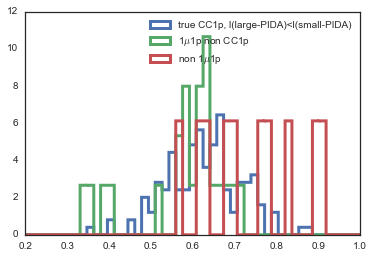

In [125]:
bins=np.linspace(0,50000,50)
# plt.hist(reduced[1].dqdx_around_vertex,histtype='step',bins=bins,linewidth=3,label=labels[1]);
# plt.hist(reduced[2].dqdx_around_vertex,histtype='step',bins=bins,linewidth=3,label=labels[2]);
# plt.hist(reduced[3].dqdx_around_vertex,histtype='step',bins=bins,linewidth=3,label=labels[3]);


# plt.hist(reduced[1].dqdx_around_vertex_non_tracks_associated,histtype='step',bins=bins,linewidth=3,label=labels[1]);
# plt.hist(reduced[2].dqdx_around_vertex_non_tracks_associated,histtype='step',bins=bins,linewidth=3,label=labels[2]);
# plt.hist(reduced[3].dqdx_around_vertex_non_tracks_associated,histtype='step',bins=bins,linewidth=3,label=labels[3]);

# plt.hist(reduced[1].dqdx_around_vertex_tracks_associated,histtype='step',bins=np.linspace(0,50000,50),linewidth=3,label=labels[1]);
# plt.hist(reduced[2].dqdx_around_vertex_tracks_associated,histtype='step',bins=np.linspace(0,50000,50),linewidth=3,label=labels[2]);
# plt.hist(reduced[3].dqdx_around_vertex_tracks_associated,histtype='step',bins=np.linspace(0,50000,50),linewidth=3,label=labels[3]);


bins=np.linspace(0.2,1,50)
plt.hist(reduced[1].dqdx_around_vertex_tracks_associated/reduced[1].dqdx_around_vertex,histtype='step',bins=bins,linewidth=3,label=labels[1],normed=1);
plt.hist(reduced[2].dqdx_around_vertex_tracks_associated/reduced[2].dqdx_around_vertex,histtype='step',bins=bins,linewidth=3,label=labels[2],normed=1);
plt.hist(reduced[3].dqdx_around_vertex_tracks_associated/reduced[3].dqdx_around_vertex,histtype='step',bins=bins,linewidth=3,label=labels[3],normed=1);


plt.legend()

NameError: name 'reduced_CC1p' is not defined

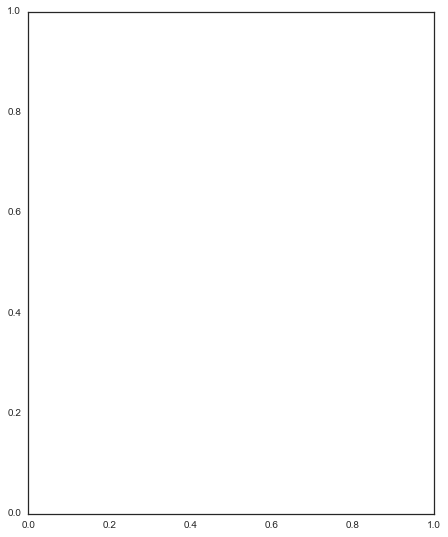

In [30]:
fig=plt.figure(figsize=(16,9))
ax=fig.add_subplot(1,2,1)
print len(reduced_CC1p)
plot_2d_hist(reduced_CC1p.truth_Ev ,reduced_CC1p.reco_CC1p_Ev , bins=np.linspace(0.2,1.5,50), xlabel='truth $E_{\\nu}$ [GeV/c]', ylabel='reco. $E_{\\nu}$ [GeV/c]',ax=ax);
ax.grid(linestyle='--',alpha=0.5)
ax=fig.add_subplot(1,2,2)
plt.hist(reduced_CC1p.truth_Ev - reduced_CC1p.reco_CC1p_Ev , bins=np.linspace(-1.,1.,50));
set_axes(ax, x_label='truth - reconstructed $E_{\\nu}$ [GeV/c]')
ax.grid(linestyle='--',alpha=0.5)
